<a href="https://colab.research.google.com/github/jameszhz1647/jameszhz1647/blob/main/cascadeVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [4]:
%cd /content/drive/MyDrive/ME499

/content/drive/MyDrive/ME499


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
import torch
torch.cuda.is_available()

True

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance

In [7]:
images_dir = '/content/drive/MyDrive/ME499/images'
annotations_dir = '/content/drive/MyDrive/ME499/annotations'

In [78]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [57]:
# !kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 97% 319M/330M [00:02<00:00, 176MB/s]
100% 330M/330M [00:02<00:00, 165MB/s]


In [ ]:
# !unzip face-mask-12k-images-dataset.zip

In [62]:
#Load train and test set
train_dir = '/content/drive/MyDrive/ME499/Face Mask Dataset/Train'
test_dir = '/content/drive/MyDrive/ME499/Face Mask Dataset/Test'
val_dir = '/content/drive/MyDrive/ME499/Face Mask Dataset/Validation'

In [63]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


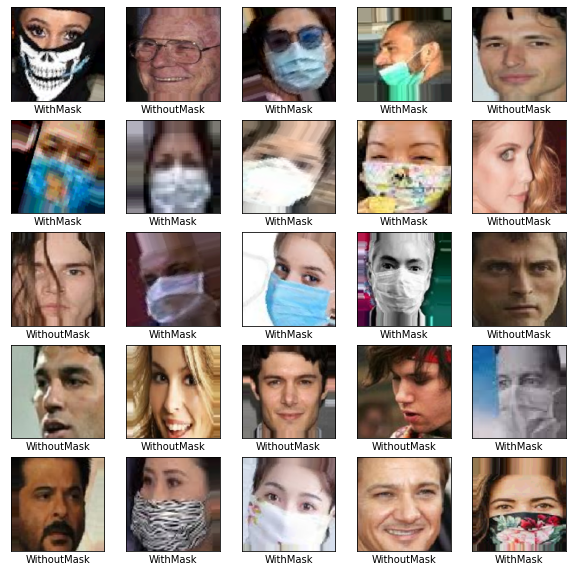

In [69]:
#show some labeled image
class_names = {v:k for k,v in train_generator.class_indices.items()}
images,labels = next(iter(train_generator))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

In [89]:
# build Model 
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [90]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [91]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20
9/9 [==============================] - 3s 258ms/step - loss: 0.5766 - accuracy: 0.6667
Epoch 2/20
9/9 [==============================] - 2s 218ms/step - loss: 0.2821 - accuracy: 0.8646
Epoch 3/20
9/9 [==============================] - 2s 218ms/step - loss: 0.1679 - accuracy: 0.9549
Epoch 4/20
9/9 [==============================] - 2s 223ms/step - loss: 0.1620 - accuracy: 0.9479
Epoch 5/20
9/9 [==============================] - 2s 219ms/step - loss: 0.1267 - accuracy: 0.9514
Epoch 6/20
9/9 [==============================] - 2s 218ms/step - loss: 0.0923 - accuracy: 0.9757
Epoch 7/20
9/9 [==============================] - 2s 218ms/step - loss: 0.1020 - accuracy: 0.9688
Epoch 8/20
9/9 [==============================] - 2s 218ms/step - loss: 0.0711 - accuracy: 0.9896
Epoch 9/20
9/9 [==============================] - 2s 221ms/step - loss: 0.0707 - accuracy: 0.9722
Epoch 10/20
9/9 [==============================] - 2s 219ms/step - loss: 0.0835 - accuracy: 0.9757
Epoch 11/20
9/9 [==

In [92]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.05897847190499306, 0.981249988079071]

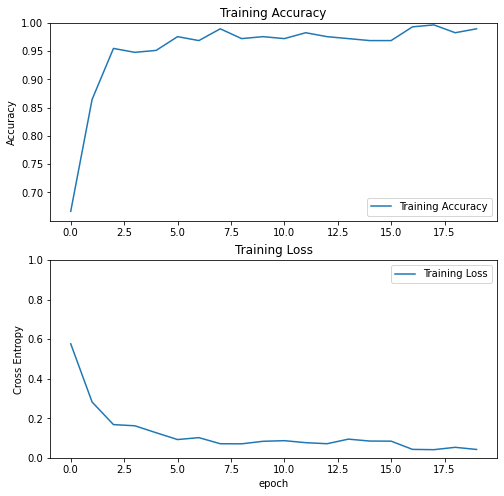

In [95]:
acc = history.history['accuracy']
loss = history.history['loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

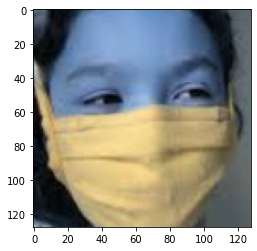

In [108]:
sample_mask_img = cv2.imread( test_dir + '/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [98]:
model.predict(sample_mask_img)

array([[0.9143416 , 0.05329059]], dtype=float32)

In [99]:
model.save('masknet.h5')

In [109]:
# #loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

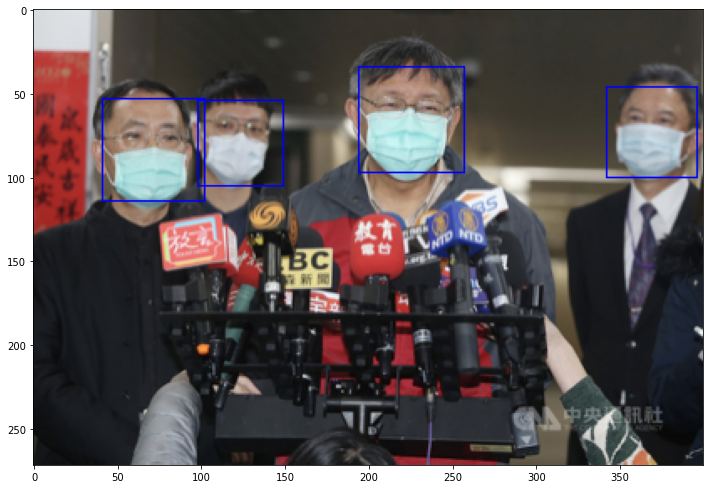

In [153]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('/content/drive/MyDrive/ME499/images/maksssksksss174.png')
# img = cv2.imread(test_dir + '/WithMask/392.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

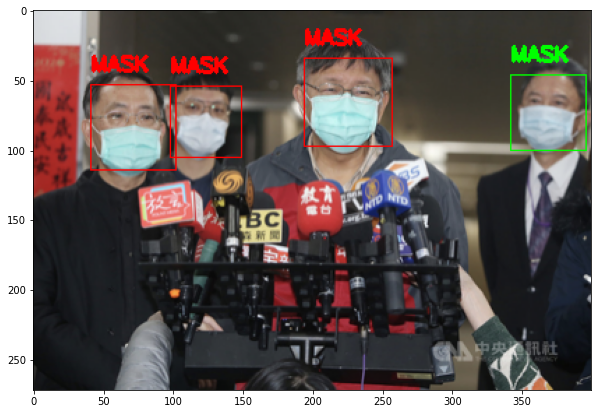

In [154]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

MIN_DISTANCE = 130;

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")
